# REDES NEURONALES CONVOLUCIONALES
## Una Aplicación para Reconocimiento de Imágenes

---
Maestría en Inteligencia Artificial

UNIR Universidad Internacional de la Rioja en México

Asignatura: Sistemas Cognitivos Artificiales.

Actividad grupal desarrollada por Edmilson Prata da Silva, Mariana Carmona Cruz, Gerardo Davila escamilla y Pedro Luis Cabrera

## 💡 Introduccíon

En esta actividad, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px">

## 📚 Librarias

Instalaciones y importaciones de librarias necesárias en el notebook.

In [ ]:
# %pip install opencv-python numpy keras scikit-image

In [12]:
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
import keras_preprocessing
import matplotlib.pyplot as plt
import time

from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras.models import load_model
from skimage.color import rgb2gray
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# This line caused the error and is commented out
# from sklearn.metrics import plot_confusion_matrix

plt.rcParams["figure.figsize"] = (20,6)

print("Importaciones ok.")

Importaciones ok.


## 📦 Carga de Datos

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.

In [15]:
# Bajamos el dataset completo una única vez
keras.utils.get_file(
    fname="simpsons.tar.gz",
    cache_dir="./",
    extract=True,
    origin="https://storage.googleapis.com/wandb-production.appspot.com/mlclass/simpsons.tar.gz"
)

# Descomprimimos el archivo en el directorio .keras/datasets
#!tar -xzf /root/.keras/datasets/simpsons.tar.gz -C /root/.keras/datasets

46129121/46129121 ━━━━━━━━━━━━━━━━━━━━ 31s 1us/step


'./datasets/simpsons_extracted'

In [8]:
def list_files_recursively(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f'{subindent}{f}')

print("Listing contents of /root/.keras/datasets/")
list_files_recursively('/root/.keras/datasets/')

Listing contents of /root/.keras/datasets/


In [ ]:
# Descomprimimos el archivo en tmp para visualizar
# !tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /tmp/simpsons

In [ ]:
# Define IMG_SIZE as it's used before MAP_CHARACTERS is fully constructed
IMG_SIZE = 60

# Define paths that will be used for dynamically loading characters
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons/train"

# Dynamically create MAP_CHARACTERS based on existing subdirectories
# This variable contains a mapping of class number to character.
# It will only include characters that actually have a directory in the training set.
MAP_CHARACTERS = {}
if os.path.exists(DATASET_TRAIN_PATH_COLAB):
    character_names = sorted([d for d in os.listdir(DATASET_TRAIN_PATH_COLAB) if os.path.isdir(os.path.join(DATASET_TRAIN_PATH_COLAB, d))])
    for i, name in enumerate(character_names):
        MAP_CHARACTERS[i] = name
    print(f"Dynamically loaded {len(MAP_CHARACTERS)} characters: {MAP_CHARACTERS}")
else:
    print(f"Error: Training path {DATASET_TRAIN_PATH_COLAB} not found. Please ensure the dataset is extracted correctly.")
    # Fallback to a predefined list if the path isn't found immediately
    # This part can be adjusted if there's a specific requirement for the 18 characters
    MAP_CHARACTERS = {
        0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
        3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel',
        7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson',
        11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak',
        14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
    }


Dynamically loaded 13 characters: {0: 'abraham_grampa_simpson', 1: 'bart_simpson', 2: 'charles_montgomery_burns', 3: 'chief_wiggum', 4: 'homer_simpson', 5: 'krusty_the_clown', 6: 'lisa_simpson', 7: 'marge_simpson', 8: 'milhouse_van_houten', 9: 'moe_szyslak', 10: 'ned_flanders', 11: 'principal_skinner', 12: 'sideshow_bob'}


In [ ]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.

    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.

    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas

    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [ ]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for label, character in map_characters.items():
        char_path = os.path.join(dirname, character)
        if os.path.exists(char_path):
            files = os.listdir(char_path)
            images = [file for file in files if file.endswith("jpg")]
            if verbose:
                print("Leyendo {} imágenes encontradas de {} para test".format(len(images), character))
            for image_name in images:
                image = cv2.imread(os.path.join(char_path, image_name))
                image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
                X_test.append(image)
                y_test.append(label)
        else:
            if verbose:
                print(f"Advertencia: Directorio de test para '{character}' no encontrado en {char_path}")
    if verbose:
        print("Leídas {} imágenes de test en total".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [ ]:
# Cargamos los datos. Los paths DATASET_TRAIN_PATH_COLAB y DATASET_TEST_PATH_COLAB
# ahora se definen antes de usar MAP_CHARACTERS en la celda anterior.
# Asegúrate de que los paths coincidan con la estructura real del dataset.
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons/train"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons/test"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 822 imágenes encontradas de abraham_grampa_simpson
Leyendo 1210 imágenes encontradas de bart_simpson
Leyendo 1074 imágenes encontradas de charles_montgomery_burns
Leyendo 888 imágenes encontradas de chief_wiggum
Leyendo 2022 imágenes encontradas de homer_simpson
Leyendo 1086 imágenes encontradas de krusty_the_clown
Leyendo 1219 imágenes encontradas de lisa_simpson
Leyendo 1162 imágenes encontradas de marge_simpson
Leyendo 972 imágenes encontradas de milhouse_van_houten
Leyendo 1307 imágenes encontradas de moe_szyslak
Leyendo 1309 imágenes encontradas de ned_flanders
Leyendo 1075 imágenes encontradas de principal_skinner
Leyendo 790 imágenes encontradas de sideshow_bob
Leyendo 91 imágenes encontradas de abraham_grampa_simpson para test
Leyendo 134 imágenes encontradas de bart_simpson para test
Leyendo 119 imágenes encontradas de charles_montgomery_burns para test
Leyendo 98 imágenes encontradas de chief_wiggum para test
Leyendo 224 imágenes encontradas de homer_simpson para test

In [ ]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

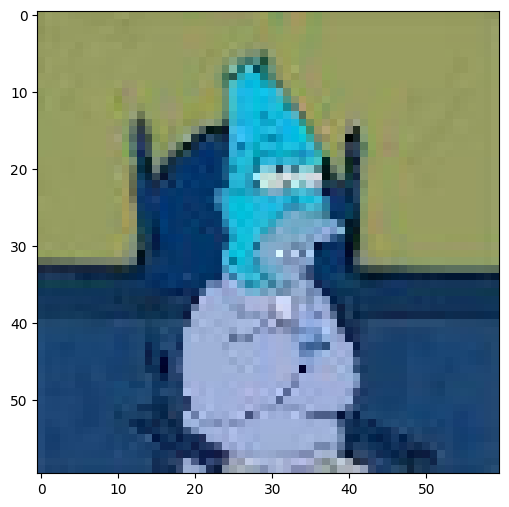

In [ ]:
plt.imshow(X_t[2])

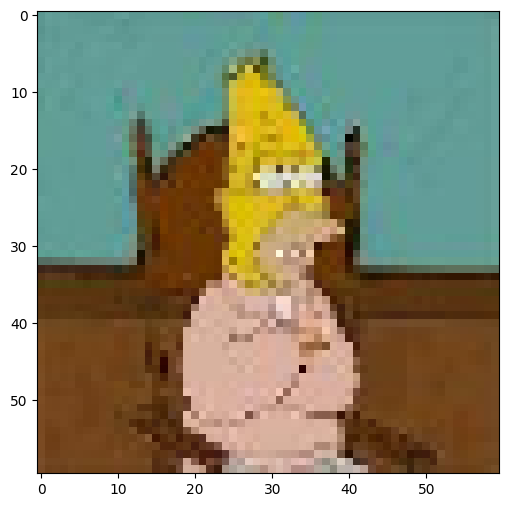

In [ ]:
plt.imshow(np.flip(X_t[2], axis=-1) )

## Ejercicio

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de, al menos, **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos para ser analizados en vuestro informe:

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas:
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

In [ ]:
# Normalización de los datos
X = X.astype('float32') / 255.0
X_t = X_t.astype('float32') / 255.0

# Convertir las etiquetas a formato categórico (one-hot encoding)
num_classes = len(MAP_CHARACTERS)
y = to_categorical(y, num_classes)
y_t = to_categorical(y_t, num_classes)

print(f"Shape of X after normalization: {X.shape}")
print(f"Shape of y after one-hot encoding: {y.shape}")
print(f"Shape of X_t after normalization: {X_t.shape}")
print(f"Shape of y_t after one-hot encoding: {y_t.shape}")

Shape of X after normalization: (14936, 60, 60, 3)
Shape of y after one-hot encoding: (14936, 13)
Shape of X_t after normalization: (1653, 60, 60, 3)
Shape of y_t after one-hot encoding: (1653, 13)


In [ ]:
# Separar los datos de entrenamiento en conjuntos de entrenamiento y validación
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")

Shape of X_train: (11948, 60, 60, 3)
Shape of y_train: (11948, 13)
Shape of X_val: (2988, 60, 60, 3)
Shape of y_val: (2988, 13)


In [ ]:
# Definir la arquitectura de la CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Mostrar un resumen del modelo
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 58, 58, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 29, 29, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 29, 29, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 504,653 (1.93 MB)

 Trainable params: 504,653 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Definir callbacks para guardar el mejor modelo y para early stopping
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val),
                    callbacks=[checkpoint, early_stopping])


Epoch 1/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1783 - loss: 2.4050
Epoch 1: val_accuracy improved from -inf to 0.42135, saving model to best_model.keras
374/374 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.1784 - loss: 2.4045 - val_accuracy: 0.4214 - val_loss: 1.8085
Epoch 2/50
373/374 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4208 - loss: 1.7779
Epoch 2: val_accuracy improved from 0.42135 to 0.63454, saving model to best_model.keras
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4210 - loss: 1.7773 - val_accuracy: 0.6345 - val_loss: 1.2089
Epoch 3/50
367/374 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5678 - loss: 1.3657
Epoch 3: val_accuracy improved from 0.63454 to 0.70649, saving model to best_model.keras
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5681 - loss: 1.3644 - val_accuracy: 0.7065 - val_loss: 0.9561
Epoch 4/50
371/374 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6407 - loss: 1.1189
Epoch 4: val_accuracy improved from 0.

In [ ]:
# Evaluar el modelo en el conjunto de test
loss, accuracy = model.evaluate(X_t, y_t, verbose=1)
print(f"Accuracy en el conjunto de test: {accuracy*100:.2f}%")


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7946 - loss: 0.7598
Accuracy en el conjunto de test: 81.73%


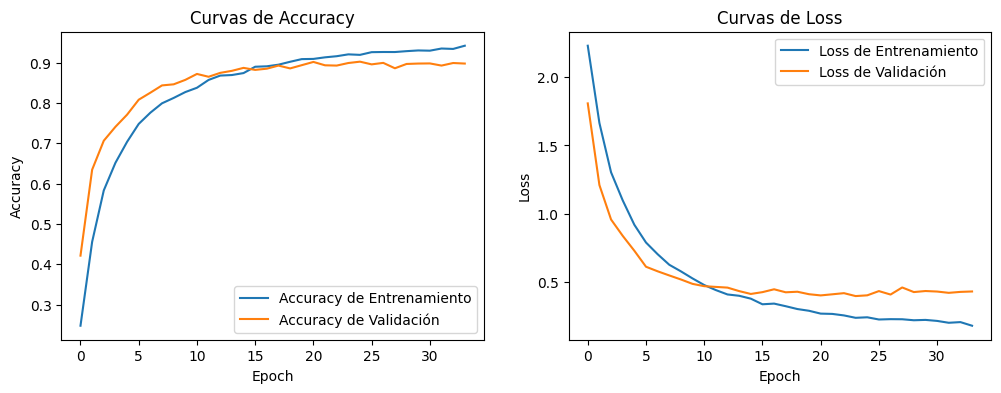

In [ ]:
# Visualizar las curvas de entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy de Validación')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Curvas de Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss de Entrenamiento')
plt.plot(history.history['val_loss'], label='Loss de Validación')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Curvas de Loss')
plt.show()

# Analisis de errores
se realiza un análisis exhaustivo de errores y una evaluación del modelo de clasificación de imágenes de personajes de The Simpsons utilizando el archivo "best_model.keras". Este análisis incluye hacer predicciones sobre el conjunto de prueba (X_t, y_t), identificar imágenes mal clasificadas, generar un reporte de clasificación y una matriz de confusión, y visualizar ejemplos de malas clasificaciones para resaltar problemas de rendimiento específicos de personajes o relacionados con las imágenes.

In [ ]:
from tensorflow.keras.models import load_model

# Load the best model saved during training
loaded_model = load_model('best_model.keras')

print("Best model loaded successfully.")

Best model loaded successfully.


**Razonamiento**:

Ahora que el mejor modelo está cargado, haré predicciones sobre el conjunto de prueba (X_t) utilizando el loaded_model. Estas predicciones estarán en forma de probabilidades, las cuales luego convertiré en etiquetas de clase. También convertiré las etiquetas verdaderas (y_t) desde la codificación one-hot a etiquetas de clase para facilitar la comparación y la identificación de clasificaciones incorrectas.

In [ ]:
y_pred_probs = loaded_model.predict(X_t)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_t, axis=1)

print("Predictions generated and true labels converted to class indices.")

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Predictions generated and true labels converted to class indices.


**Reasoning**:
To identify misclassified images, I will compare the predicted class labels with the true class labels from the test set and store the indices where they don't match.



In [ ]:
misclassified_indices = np.where(y_pred_classes != y_true_classes)[0]
num_misclassified = len(misclassified_indices)

print(f"Number of misclassified images: {num_misclassified}")

Number of misclassified images: 308


Para analizar el rendimiento del modelo para cada personaje e identificar las clases que presentan problemas, generaré un informe de clasificación utilizando sklearn.metrics.classification_report. Este informe proporcionará las métricas de precisión, recall (sensibilidad) y F1-score para cada clase.



In [ ]:
class_names = [MAP_CHARACTERS[i] for i in sorted(MAP_CHARACTERS.keys())]
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print("Classification Report:")
print(report)

Classification Report:
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.85      0.68      0.76        91
            bart_simpson       0.67      0.66      0.66       134
charles_montgomery_burns       0.66      0.81      0.72       119
            chief_wiggum       0.86      0.85      0.85        98
           homer_simpson       0.80      0.92      0.86       224
        krusty_the_clown       0.95      0.92      0.93       120
            lisa_simpson       0.62      0.79      0.69       135
           marge_simpson       0.91      0.89      0.90       129
     milhouse_van_houten       0.91      0.79      0.85       107
             moe_szyslak       0.86      0.72      0.79       145
            ned_flanders       0.96      0.84      0.90       145
       principal_skinner       0.85      0.76      0.80       119
            sideshow_bob       0.89      0.89      0.89        87

                accuracy                           

Para visualizar la distribución de predicciones correctas e incorrectas en todas las clases e identificar clases específicas que suelen confundirse entre sí, generamos una matriz de confusión utilizando sklearn.metrics.confusion_matrix y matplotlib.pyplot.

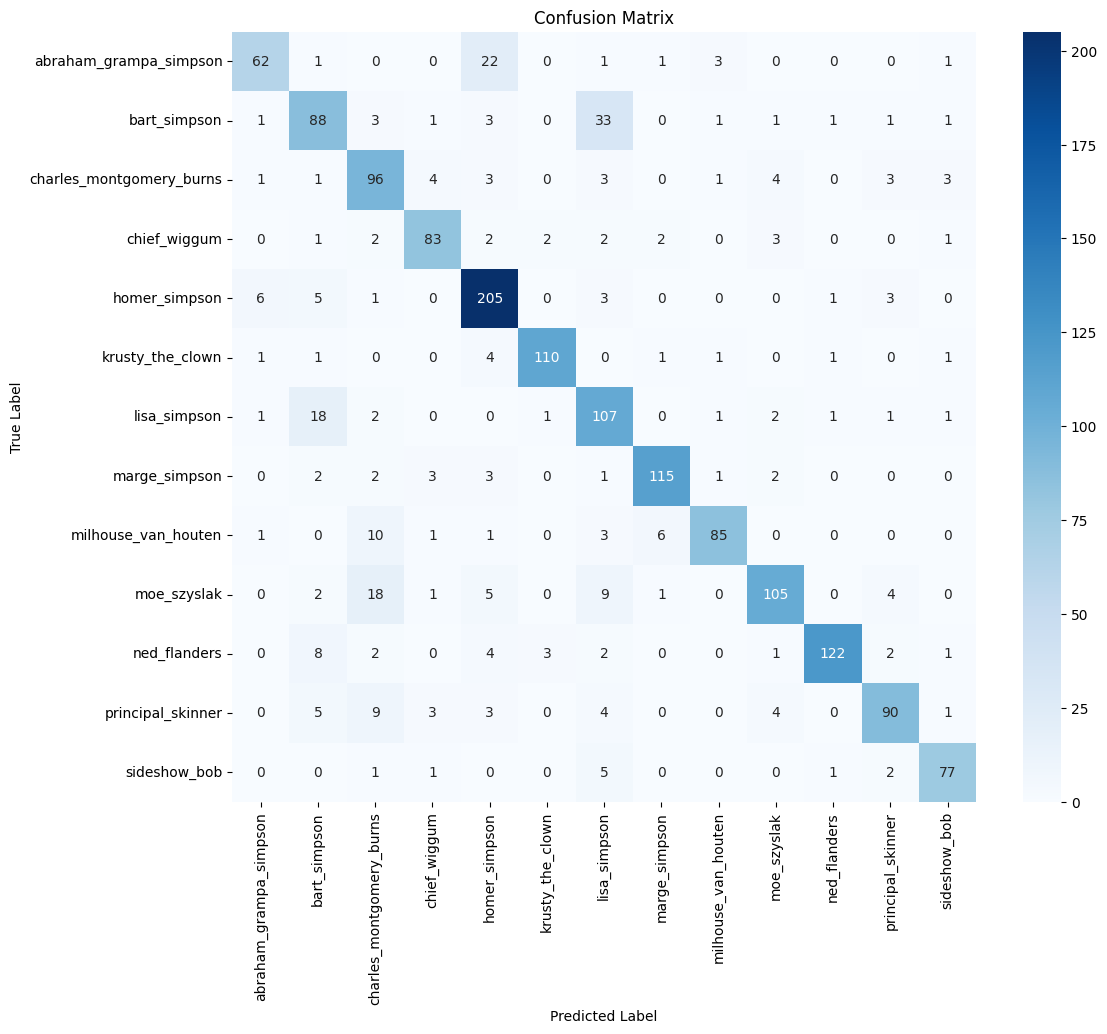

Confusion matrix plotted successfully.


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
print("Confusion matrix plotted successfully.")

Para analizar los errores del modelo, mostraremos algunas imágenes mal clasificadas junto con sus etiquetas reales y predichas, con el fin de identificar confusiones comunes.



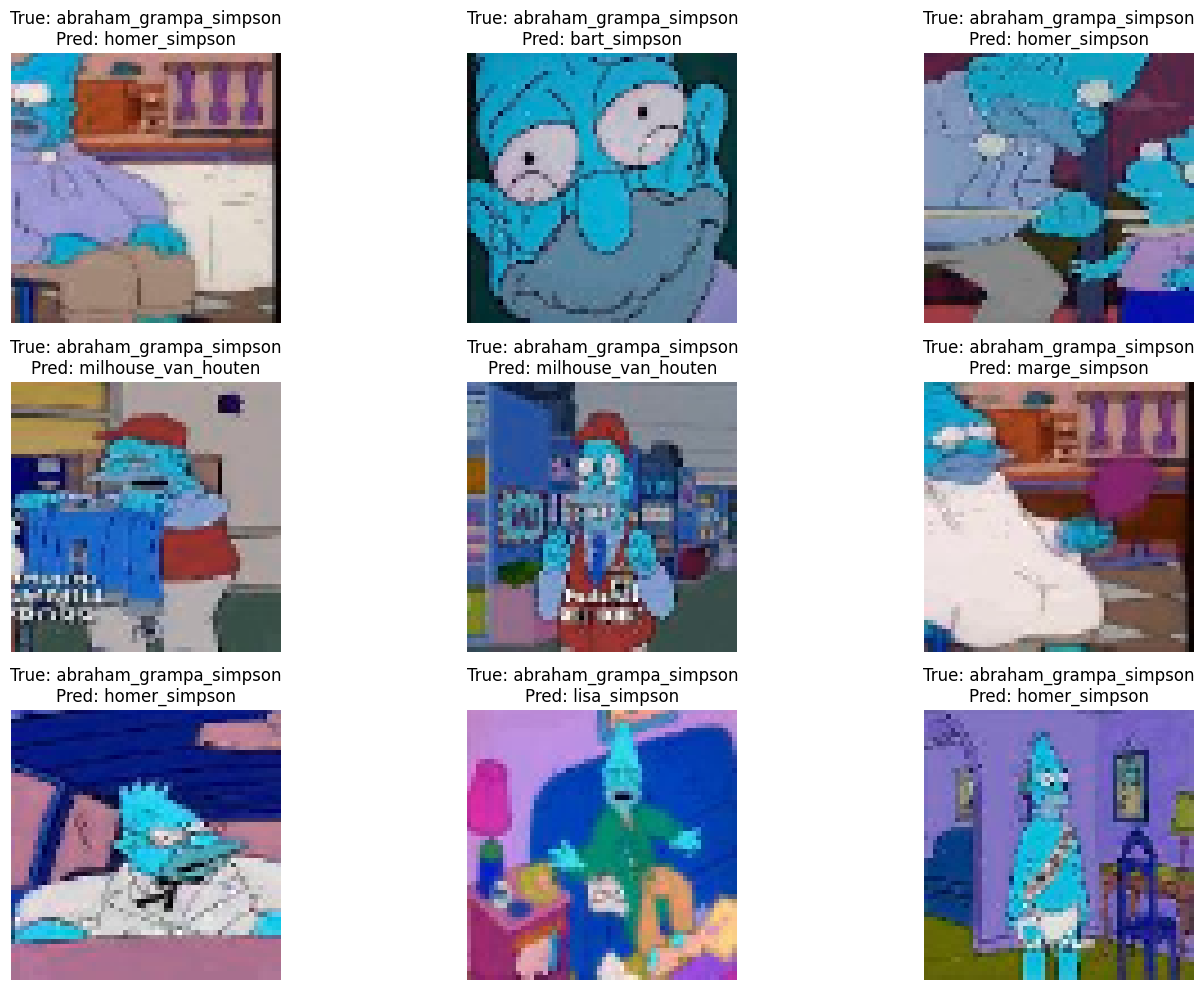

Sample misclassified images displayed.


In [ ]:
plt.figure(figsize=(15, 10))
for i, idx in enumerate(misclassified_indices[:9]): # Displaying first 9 misclassified images
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_t[idx])
    true_label = class_names[y_true_classes[idx]]
    predicted_label = class_names[y_pred_classes[idx]]
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()
print("Sample misclassified images displayed.")